# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load
from typing import Union, Tuple, List
from sklearn.preprocessing import OneHotEncoder, StandardScaler # Imputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from collections import Counter

# magic word for producing visualizations in notebook
%matplotlib inline

pd.options.display.max_rows = 20
pd.options.display.max_columns = 10

# Project constants
PROCESSED_DATA_PATH = './data/processed_data.pk'
CLUSTER_MODEL_PATH = './model/cluster_model.pk'

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [3]:
# load in the data
azdias = pd.read_csv('./data/Udacity_AZDIAS_052018.csv', sep=';')

C:\Users\flopezr81\AppData\Local\Temp\ipykernel_5952\893584662.py:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  azdias = pd.read_csv('./data/Udacity_AZDIAS_052018.csv', sep=';')


In [4]:
# We can see that the warning is because of the missing values encoding in the two related features, which are integer. 
# Additionally, CAMEO_DEUG_2015 has some non-missing values set as strings.
for col in [18, 19]:
    print(azdias.columns[col], ': ', azdias[azdias.columns[col]].unique())

CAMEO_DEUG_2015 :  [nan 8.0 4.0 2.0 6.0 1.0 9.0 5.0 7.0 3.0 '4' '3' '7' '2' '8' '9' '6' '5'
 '1' 'X']
CAMEO_INTL_2015 :  [nan 51.0 24.0 12.0 43.0 54.0 22.0 14.0 13.0 15.0 33.0 41.0 34.0 55.0 25.0
 23.0 31.0 52.0 35.0 45.0 44.0 32.0 '22' '24' '41' '12' '54' '51' '44'
 '35' '23' '25' '14' '34' '52' '55' '31' '32' '15' '13' '43' '33' '45'
 'XX']


In [5]:
n_rows_gen_demo, n_cols_gen_demo = azdias.shape
print('General demographics: persons (rows) = {}, features (columns) = {}'.format(n_rows_gen_demo, n_cols_gen_demo))

General demographics: persons (rows) = 891221, features (columns) = 366


In [6]:
# Looking at the first 5 rows of the general demographics dataframe
azdias.head(5)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,...,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,...,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,...,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,...,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,...,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,...,9.0,3.0,4,1,3


In [7]:
# Looking at the last 5 rows of the general demographics dataframe
azdias.tail(5)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,...,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
891216,825761,-1,5.0,17.0,NaN,...,4.0,3.0,4,2,3
891217,825771,-1,9.0,16.0,NaN,...,9.0,5.0,6,1,2
891218,825772,-1,1.0,17.0,NaN,...,5.0,7.0,4,2,2
891219,825776,-1,9.0,0.0,17.0,...,9.0,5.0,5,1,1
891220,825787,-1,1.0,0.0,NaN,...,3.0,4.0,3,1,4


In [8]:
# Looking at the summary statistics of the general demographics dataframe
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,...,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,...,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,...,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,...,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,...,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,...,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,...,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,...,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,...,9.000000,8.000000,6.000000,2.000000,9.000000


In [9]:
# Looking at the data features of the general demographics dataframe
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


In [10]:
customers = pd.read_csv('./data/Udacity_CUSTOMERS_052018.csv', sep=';')

C:\Users\flopezr81\AppData\Local\Temp\ipykernel_5952\1418119627.py:1: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  customers = pd.read_csv('./data/Udacity_CUSTOMERS_052018.csv', sep=';')


### Step 0.1: Assess Missing Data

The first preprocessing step to take is to deal with the missing values per columns and rows. I have splitted this step into three substeps: 1) the conversion of encoded missing values into nans, 2) the removal of outliers columns, and 3) the removal of outlier rows from the remaining columns.

#### Step 0.1.1: Convert Missing Value Codes to NaNs
By looking at the excel file ´DIAS Attributes - Values 2017.xlsx´, I figured out that there are missing values in the features encoded as either specific numbers like 0, -1 or letters like 'X' or 'XX'. Therefore, I'm gonna read this file to detect these encodings and replace each appearance in the dataframe with nan values. Additonally, I added an extra column Type to set the type of each feature: binary (2-level categories), categorical (>=3 levels), ordinal or numeric.  

In [11]:
# Reading the excel file with info on dias attributes
dias_att = pd.read_excel(io='./data/DIAS Attributes - Values 2017.xlsx', sheet_name = 'Tabelle1', skiprows=1)

In [12]:
dias_att.head(10)

,Unnamed: 0,Attribute,Description,Value,Meaning,Type
0,NaN,AGER_TYP,best-ager typology,-1,unknown,categorical
1,NaN,NaN,NaN,0,no classification possible,NaN
2,NaN,NaN,NaN,1,passive elderly,NaN
3,NaN,NaN,NaN,2,cultural elderly,NaN
4,NaN,NaN,NaN,3,experience-driven elderly,NaN
5,NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown,ordinal
6,NaN,NaN,NaN,1,< 30 years,NaN
7,NaN,NaN,NaN,2,30 - 45 years,NaN
8,NaN,NaN,NaN,3,46 - 60 years,NaN
9,NaN,NaN,NaN,4,> 60 years,NaN


In [13]:
# We clean the excel
# We drop the first null
dias_att.drop(axis=1, columns= 'Unnamed: 0', inplace=False)

,Attribute,Description,Value,Meaning,Type
0,AGER_TYP,best-ager typology,-1,unknown,categorical
1,NaN,NaN,0,no classification possible,NaN
2,NaN,NaN,1,passive elderly,NaN
3,NaN,NaN,2,cultural elderly,NaN
4,NaN,NaN,3,experience-driven elderly,NaN
...,...,...,...,...,...
2254,NaN,NaN,2,smart,NaN
2255,NaN,NaN,3,fair supplied,NaN
2256,NaN,NaN,4,price driven,NaN
2257,NaN,NaN,5,seeking orientation,NaN


In [14]:
# We create a two-column dataframe based on dias_att where we have the name of the feature in one column and the list of 
# missing/unkown values in the other
att_to_nan = dias_att.loc[dias_att['Meaning'] == 'unknown', ['Attribute', 'Value']]
att_to_nan['Value'] = att_to_nan['Value'].astype('str')
att_to_nan.head(10)

,Attribute,Value
0,AGER_TYP,-1
5,ALTERSKATEGORIE_GROB,"-1, 0"
33,ANREDE_KZ,"-1, 0"
40,BALLRAUM,-1
48,BIP_FLAG,-1
51,CAMEO_DEUG_2015,X
61,CAMEO_DEU_2015,XX
106,CAMEO_DEUINTL_2015,-1
132,CJT_GESAMTTYP,0
392,D19_KK_KUNDENTYP,-1


In [15]:
# Common attributes between azdias and loaded excel file
n_common_feat = len(set(att_to_nan['Attribute'].unique()).intersection(azdias.columns))
print('Common attributes between azdias and loaded excel file: ', n_common_feat)

Common attributes between azdias and loaded excel file:  223


In [16]:
def convert_if_num(element: str) -> Union[str, int]:
    '''
    This function converts an element to a numeric type if the string element is a number. Otherwise, it remains as a string

    INPUT: element -  string to check if it is a number.
    OUTPUT: element converted into a number if numeric. Otherwise, keep it as string
    '''

    # Check for positive numbers
    if element.isnumeric():
        return int(element)

    # Check for negative numbers
    if element[0] == '-' and element[1:].isnumeric:
        return -1*int(element[1:])

    return element
    

# Identify missing or unknown data values and convert them to NaNs.
def replace_missing_unknown_with_nan(*, df_data: pd.DataFrame, df_mu: pd.DataFrame) -> pd.DataFrame:
    '''
    This function replaces the missing or unknown values in the columns of a given dataframe with Nan values.

    INPUT: df_data - dataframe whose columns may contain some missing or unknown values to replace with Nan values.
           df_mu - dataframe whose rows contain a reference to a column in df_data and a list of values representing missing or unknown values in the 
                   form of a string.
    OUTPUT: df_data_nan - dataframe with the unknow values from df_data replaced with nan values.
    '''

    df_data_nan = df_data.copy()
    for i, row in df_mu.iterrows():
        if row['Attribute'] not in df_data.columns:
            continue
        
        missing_or_unknown_vals = list(map(convert_if_num, row['Value'].split(',')))
        df_data_nan[row['Attribute']].replace(to_replace=missing_or_unknown_vals, value=np.nan, inplace=True)
    
    return df_data_nan

azdias_nans = replace_missing_unknown_with_nan(df_data=azdias, df_mu=att_to_nan)
n_nans = azdias_nans.isnull().sum().sum()
print('Total amount of nulls: ', n_nans)

Total amount of nulls:  34504760


#### Step 0.1.2: Assess Missing Data in Each Column
There might be columns that are outliers in terms of the proportion of values that are missing. To detect them and drop from the analysis, I'm gonna use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts.

True

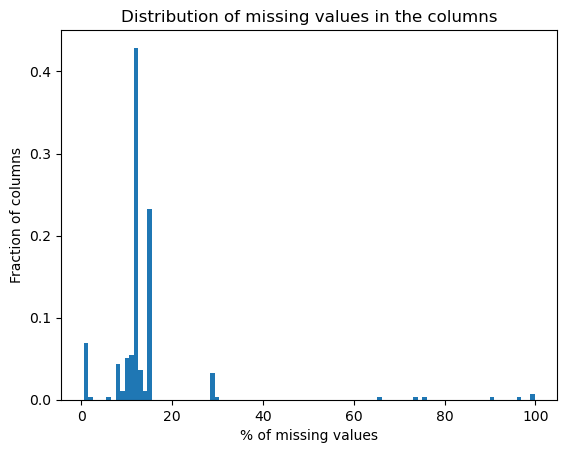

In [17]:
def show_nans_distribution(*, df: pd.DataFrame, cols_or_rows: int, n_bins: int = 100) -> bool:
    '''
    This function plots a histogram with the distribution of nans either per column or per row.

    INPUT: 
      df (pandas dataframe):            dataframe holding the data with all missing values converted into nans.
      cols_or_rows (integer in [0, 1]): 0: nans per column/ 1: nans per row.
      n_bins (integer):                 Number of bins to be used in the histogram 
    
    OUTPUT: Whether or not the method was able to plot the histogram.
    '''
    
    if cols_or_rows not in [0, 1]:
        print('{} is an invalid value for cols_or_rows parameter'.format(cols_or_rows))
        return False
    
    # Calculate the percentage of missing values for each column/row
    missing_percentage = df.isnull().mean(axis=cols_or_rows)*100

    # Filter out columns/rows having no missing values
    missing_percentage = missing_percentage.loc[missing_percentage > 0]
    
    # Determine the customized message in the distinct plot labels 
    msg = 'rows' if cols_or_rows else 'columns'
    
    # Plot the histogram
    missing_percentage.plot(kind='hist', bins=n_bins, density = True, 
                            title = "Distribution of missing values in the " + msg, 
                            xlabel="% of missing values", ylabel="Fraction of " + msg)
    
    return True
    
# Ploting the distribution of missing values per column
show_nans_distribution(df=azdias_nans, cols_or_rows=0)

From the above histogram, we can see that the vast majority of columns has no more than **30%** of missing values. Therefore, that value can be used as a cutoff for dropping the outlier columns.

In [18]:
def drop_outlier_columns(*, df_data: pd.DataFrame, cutoff: int = 50)-> Tuple[pd.DataFrame, int]:
    '''
    This function drops the columns from the dataframe having an amount of missing values greater than cutoff value.

    INPUT: df_data - dataframe whose columns may contain some missing values.
           cutoff  - limit value in % from which columns with higher % of missing values will be dropped.  
    OUTPUT: reduced dataframe with the dropped features.
            list with the names of the dropped features.
    '''

    # Calculating the percentage of missing values for each column
    series_nan_counts = df_data.isnull().mean(axis=0)*100

    # Getting the row names having a number of missing values greater than cutoff value 
    dropped_columns = list(series_nan_counts.loc[series_nan_counts > cutoff].index)

    # Dropping the columns matching the above selected row names
    df_reduced_data = df_data.drop(dropped_columns, axis='columns')

    # Returning the reduced data frame in order to not modify the original one 
    return df_reduced_data, dropped_columns


red_azdias_nans, dropped_cols = drop_outlier_columns(df_data=azdias_nans, cutoff=30)
print('Removed features: ', dropped_cols)

Removed features:  ['AGER_TYP', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KK_KUNDENTYP']


#### Step 0.1.3: Assess Missing Data in Each Row
I'm gonna do a similar approach to detect and remove the outlier rows.

True

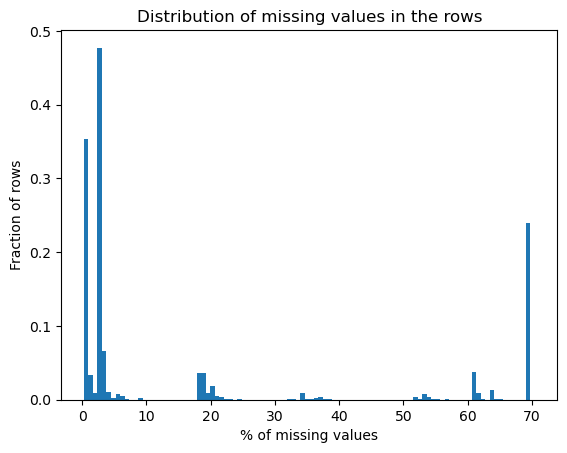

In [19]:
# Ploting the distribution of missing values per row
show_nans_distribution(df=red_azdias_nans, cols_or_rows=1)

From the above histogram, we can see that the vast majority of rows has no more than **30%** of missing values. Therefore, that value can be used as a cutoff for dropping the outlier rows.

In [20]:
# Dropping outlier rows 
cutoff = 30

# Calculating the percentage of missing values for each column
red_azdias_nans['n_miss_vals'] = red_azdias_nans.isnull().mean(axis=1)*100
red_azdias_nans2 = red_azdias_nans.loc[red_azdias_nans['n_miss_vals'] <= cutoff].drop(columns = 'n_miss_vals')
n_removed_rows = sum(red_azdias_nans['n_miss_vals'] > cutoff)
print('Amount of removed rows: ', n_removed_rows)

Amount of removed rows:  105801


### Step 0.2: Select and Re-Encode Features

Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, we need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, I will make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling is also necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, I will conduct an investigation of the categorical and mixed-type features and make a decision on each of them, whether I will keep, drop, or re-encode each. Then, in the last part, I will create a new dataframe with only the selected and engineered columns.

In [107]:
valid_features = red_azdias_nans3.columns.tolist()
valid_features_types = dias_att.loc[dias_att['Attribute'].isin(valid_features), ['Attribute', 'Type']]
valid_features_types['Type'].value_counts()

Type
ordinal        221
mixed           18
categorical     17
numeric         10
binary           4
interval         1
Name: count, dtype: int64

#### Step 0.2.1: Curse of dimensionality

As the number of features grows, the amount of data we need to accurately be able to distinguish between these features (in order to give us a prediction) and generalize our model (learned function) grows EXPONENTIALLY [1]. Below is a simple function I use to reduce the cardinality of a feature. The idea is very simple. Leave instances belonging to a value with high frequency as they are and replace the other instances with a new category which we will call other.

1. Choose a threshold
2. Sort unique values in the column by their frequency in descending order
3. Keep adding the frequency of these sorted (descending) unique values until a threshold is reached.

These are the unique categories we will keep and instances of all other categories shall be replaced by “other”. Let’s run through a quick example before going through the code. Say our column colour has 100 values and our threshold is 90% (that is 90). We have 5 different categories of colours: Red (50), Blue(40), Yellow (5), Green (3) and Orange (2). The numbers within the bracket indicate how many instances of that category are present in the column.

We see that Red (50)+Blue (40) reaches our threshold of 90. In that case, we retain only 2 categories (Red, Blue) and mark all other instances of other colours as “Other”.

Thus we have reduced cardinality from 5 to 3 (Red, Blue, Other)

Here is the utility function I wrote to facilitate this. It’s well commented and follows exactly what I described above so you won’t have a problem following along. We can set a custom threshold and the return_categories option optionally lets us see the list of all unique values after reducing cardinality.

In [39]:
def cumulatively_categorise(df_feat: pd.DataFrame, df_type: pd.DataFrame, cutoff: float = 0.75) -> pd.DataFrame:
    '''
    This function treats the curse of dimensionality by searching for low amounts of categories and replacing them by one
    grouping category 'others'

    INPUT: 
        df_feat (pandas dataframe) - dataframe holding the values of each feature.
        df_type (pandas dataframe) - dataframe holding the types of each feature.
        cutoff (float) - Threshold value for identifying the low amount categories.  
    
    OUTPUT: dataframe holding the transformed values of each feature
    '''  
    
    new_df = df_feat.copy()
    features = df_type.loc[df_type['Type'] == 'categorical', 'Attribute'].to_list()
    
    for feature in features:
    
        # Drop missing values from the analysis
        feat_vals = new_df[feature].dropna()
    
        # Find the threshold value using the percentage and number of instances in the column
        cutoff_value = int(cutoff*len(feat_vals))
    
        # Initialise to nan the list for our new minimised categories
        categories_list = [np.nan]
    
        # Initialise a variable to calculate the sum of frequencies
        s = 0
    
        # Initialize flag of other category needed to False
        other_cat = False
    
        # Create a counter dictionary of the form unique_value: frequency
        counts = Counter(feat_vals)
        
        # Loop through the category name and its corresponding frequency after sorting the categories by descending order of 
        # frequency 
        for i, j in counts.most_common():
        
            # Add the frequency to the global sum
            s += dict(counts)[i]
    
            # Append the category name to the list
            categories_list.append(i)
        
            # Check if the global sum has reached the threshold value, if so break the loop 
            if s >= cutoff_value:
                other_cat = True
                break
      
        if other_cat:
            # Replace all instances not in our new categories by Other  
            new_df[feature] = new_df[feature].apply(lambda x: x if x in categories_list else 'Other')
    
    # Return transformed dataframe
    return new_df


# Call the function with a default threshold of 75%
valid_features = red_azdias_nans2.columns.tolist()
valid_features_types = dias_att.loc[dias_att['Attribute'].isin(valid_features), ['Attribute', 'Type']]
red_azdias_nans3 = cumulatively_categorise(df_feat=red_azdias_nans2, df_type=valid_features_types)

#### Step 0.2.2: Re-Encode Categorical Features

Each level of the categorical features needs to be encoded as a dummy variable  (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)). Depending on the number of categories, the following encodings will be performed:
- Two-level or binary categorical features taking
    - numeric values will be kept as they are.
    - non-numeric values will be re-encoded as 0-1 values.
- Multi-level categorical features (>=3) will be either encoded using multiple dummy variables or dropped from the analysis.

In [118]:
def explore_feature_types(df_feat: pd.DataFrame, df_type: pd.DataFrame, feat_type: str) -> List[str]:
    '''
    This function shows the unique values of the dataframe features related to the given type.

    INPUT: 
        df_feat (pandas dataframe) - dataframe holding the values of each feature.
        df_type (pandas dataframe) - dataframe holding the types of each feature.
        feat_type (string) - .  
    
    OUTPUT: List of strings representing the names of the features.
    '''
        
    feature_types = df_type.loc[df_type['Type'] == feat_type, 'Attribute'].to_list()

    for feat in feature_types:
        classes = df_feat[feat].dropna().unique()
        print(feat, classes)
        
    return feature_types

# Exploring the binary features       
binary_feat = explore_feature_types(df_feat=red_azdias_nans3, df_type=valid_features_types, feat_type='binary')

ANREDE_KZ [2 1]
GREEN_AVANTGARDE [0 1]
OST_WEST_KZ ['W' 'O']
VERS_TYP [2. 1.]


['ANREDE_KZ', 'GREEN_AVANTGARDE', 'OST_WEST_KZ', 'VERS_TYP']

In [111]:
# Replacing the non 0 or 1 values
red_azdias_nans3['ANREDE_KZ'].replace({2: 0}, inplace = True)
red_azdias_nans3['VERS_TYP'].replace({1: 0, 2: 1}, inplace = True)
red_azdias_nans3['OST_WEST_KZ'].replace({'W': 0, 'O': 1}, inplace = True)

array([0, 1], dtype=int64)

In [119]:
# Exploring the categorical features       
categorical_feat = explore_feature_types(df_feat=red_azdias_nans3, df_type=valid_features_types, feat_type='categorical')

CAMEO_DEUG_2015 [8.0 4.0 2.0 6.0 1.0 9.0 5.0 7.0 3.0 '4' '3' '7' '2' '8' '9' '6' '5' '1']
CAMEO_DEU_2015 ['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '7A' '5D' '9E'
 '9B' '1B' '8B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F'
 '5F' '1C']
CJT_GESAMTTYP [5. 3. 2. 4. 1. 6.]
D19_KONSUMTYP [9. 1. 4. 3. 6. 5. 2.]
FINANZTYP [1 6 5 2 4 3]
GEBAEUDETYP [8. 1. 3. 2. 6. 4. 5.]
GFK_URLAUBERTYP [10.  1.  5. 12.  9.  3.  8. 11.  4.  7.  2.  6.]
KBA05_MAXHERST [2. 5. 3. 1. 4. 9.]
KBA05_SEG6 [1. 0. 9.]
LP_FAMILIE_FEIN [ 5.  1.  0. 10.  2.  7. 11.  8.  4.  6.  9.  3.]
LP_FAMILIE_GROB [3. 1. 0. 5. 2. 4.]
LP_STATUS_FEIN [ 2.  3.  9.  4.  1. 10.  5.  8.  6.  7.]
LP_STATUS_GROB [1. 2. 4. 5. 3.]
NATIONALITAET_KZ [1 3 2 0]
SHOPPER_TYP [3. 2. 1. 0.]
TITEL_KZ [0. 4. 1. 3. 5. 2.]
ZABEOTYP [5 3 4 1 6 2]


I decided to drop CAMEO_DEUG_2015, LP_STATUS_GROB, LP_FAMILIE_GROB as we have more specific variables accounting for them in CAMEO_DEU_2015, LP_STATUS_FEIN, LP_FAMILIE_FEIN.

In [120]:
# Preliminar steps to re-encode categorical feature(s) to be kept in the analysis.
kept_categorical_feat =  categorical_feat.copy()

# Drop categorial features that are copies of other more specific ones
rem_categorical_feat = ['CAMEO_DEUG_2015', 'LP_STATUS_GROB', 'LP_FAMILIE_GROB']
kept_categorical_feat = list(set(kept_categorical_feat).difference(rem_categorical_feat))
red_azdias_nans3.drop(rem_categorical_feat, axis=1, inplace = True)

# Re-encoding the categorical features to kept in the analysis.
red_azdias_nans3_encoded = pd.get_dummies(red_azdias_nans3, columns=kept_categorical_feat)
print(red_azdias_nans3_encoded.head(5))

#### Step 0.2.3: Engineer Mixed-Type Features

In [ ]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
print('PRAEGENDE_JUGENDJAHRE distinct values: ', np.sort(.PRAEGENDE_JUGENDJAHRE.unique()))

In [1]:
# Engineer Binary variable movement: by looking at the meaning of each distinct value of PRAEGENDE_JUGENDJAHRE in the Data_Dictionary.md file, 
# I splitted the values into two groups, current movements and new movements as follows:
current_movements = [1, 3, 5, 8, 10, 12, 14]
new_movements = [2, 4, 6, 7, 9, 11, 13, 15]

# First, I create a new column and copy the same values of column PRAEGENDE_JUGENDJAHRE
red_azdias_nans3_encoded['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = red_azdias_nans3_encoded.['PRAEGENDE_JUGENDJAHRE']

# Second, we code the values of current movements as 0 
red_azdias_nans3_encoded['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].replace(current_movements, 0, inplace=True)

# Third, we code the values of new movements as 1 
red_azdias_nans3_encoded['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].replace(new_movements, 1, inplace=True)

# Fourth, we check that all values of the new column are either 0 or 1
print('PRAEGENDE_JUGENDJAHRE_MOVEMENT distinct values: ', red_azdias_nans3_encoded['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].unique())

In [ ]:
# Engineer interval-type variable decade: by looking at the meaning of each distinct value of PRAEGENDE_JUGENDJAHRE in the Data_Dictionary.md file, I
# find out that the values onto one of the following decades 40, 50, 60, 70, 80, 90. So, I create a dict mapping the values to their corresponding 
# decade as follows:
val_to_dec = {1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60, 7: 60, 8: 70, 9: 70, 10: 80, 11: 80, 12: 80, 13: 80, 14: 90, 15: 90}

# First, I create a new column and copy the same values of column PRAEGENDE_JUGENDJAHRE
red_azdias_nans3_encoded['PRAEGENDE_JUGENDJAHRE_DECADE'] = red_azdias_nans3_encoded['PRAEGENDE_JUGENDJAHRE']

# Second, we code the values according to their corresponding decade set in the dict val_to_dec 
red_azdias_nans3_encoded['PRAEGENDE_JUGENDJAHRE_DECADE'].replace(val_to_dec, inplace=True)

# Third, we check that all values of the new column are within decades 40-90
print('PRAEGENDE_JUGENDJAHRE_DECADE distinct values: ', np.sort(red_azdias_nans3_encoded['PRAEGENDE_JUGENDJAHRE_DECADE'].unique()))

In [ ]:
# Investigate "CAMEO_INTL_2015"
print('CAMEO_INTL_2015 distinct values: ', red_azdias_nans3_encoded['CAMEO_INTL_2015'].unique())

In [ ]:
# Engineer the two new variables, wealth and life stage: By looking at the meaning of each distinct value of CAMEO_INTL_2015 in the Data_Dictionary.md 
# file, I found out that the first digit of each value corresponds to the wealth, whereas the second one do so to life stage.
# Prior to encode the values to the variables, I create two auxiliary functions to use in the apply method of pandas for getting the appropriate digit 
# of the values:

def get_wealth_value(n: str) -> int:
    if pd.isnull(n):
        return np.nan

    return int(n[0])

def get_life_stage_value(n: str) -> int:
    if pd.isnull(n):
        return np.nan
        
    return int(n[1])

In [ ]:
# I think the values for wealth are: 1: Wealthy; 2: Prosperous; 3: Comfortable; 4: Less affluent; 5: Pooerer
red_azdias_nans3_encoded['CAMEO_INTL_2015_WEALTH'] = red_azdias_nans3_encoded['CAMEO_INTL_2015'].apply(get_wealth_value)
print('CAMEO_INTL_2015_WEALTH distinct values: ', np.sort(red_azdias_nans3_encoded['CAMEO_INTL_2015_WEALTH'].unique()))

In [ ]:
# I think the values for life stage are: 1: Singles; 2: Young with children; 3: School age children;
# 4: Older families & mature couples; 5: Elders in retirement
red_azdias_nans3_encoded['CAMEO_INTL_2015_LIFE_STAGE'] = red_azdias_nans3_encoded['CAMEO_INTL_2015'].apply(get_life_stage_value)
print('CAMEO_INTL_2015_LIFE_STAGE distinct values: ', np.sort(red_azdias_nans3_encoded['CAMEO_INTL_2015_LIFE_STAGE'].unique()))

In [14]:
df_processed_data = azdias

In [23]:
def save_data_to_pickle(data: Union[pd.DataFrame, GridSearchCV], file_path: str):
    '''
    INPUT:
    data - (either pandas dataframe or GridSearchCV) the data object to save into a pickle file
    file_path - (string) the path + the file name of the pickle file   
    
    OUTPUT: None 
    
    '''
    try:
        saved_pickle = dump(df_processed_data, file_path)
    except:
        print('Unable to save pickle file {}'.format(file_path))
    else:
        print('Saved pickle file {}'.format(file_path))

In [24]:
# Load the fitted clsuter model to a pickle file for later use
save_data_to_pickle(data=df_processed_data, file_path=PROCESSED_DATA_PATH)

Saved pickle file ./data/processed_data.pk


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [26]:
def load_data_from_pickle_file(file_path: str) -> Union[pd.DataFrame, GridSearchCV]:
    '''
    INPUT:
    file_path - (string) the path + the file name of the pickle file
    
    OUTPUT:
    data - (either pandas dataframe or GridSearchCV) the data object to save into a pickle file
    '''
    try:
        df_processed_data = load(file_path)
    except:
        print('Unable to load pickle file {}'.format(file_path))
        return pd.DataFrame()
    else:
        print('Loaded pickle file {}'.format(file_path))
        return df_processed_data

In [27]:
# Load the processed data from a pickle file
df_processed_data = load_data_from_pickle_file(file_path=PROCESSED_DATA_PATH)

Loaded pickle file ./data/processed_data.pk


In [28]:
df_processed_data.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,...,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,...,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,...,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,...,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,...,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,...,9.0,3.0,4,1,3


In [ ]:
# Save the fitted cluster model to a pickle file for later use
save_data_to_pickle(data=cluster_model, file_path=CLUSTER_MODEL_PATH)

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
# Loading the fitted cluster model from a pickle file
cluster_model = load_data_from_pickle_file(file_path=CLUSTER_MODEL_PATH)

In [6]:
mailout_train = pd.read_csv('./data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

C:\Users\flopezr81\AppData\Local\Temp\ipykernel_9276\1838270115.py:1: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_train = pd.read_csv('./data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')


# References

[1] Sangani R (2021). Dealing with features that have high cardinality. Medium. 5 min read. August 4 2021.